# Data block API foundations

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("../src/")

In [3]:
#export
from nb_06 import *

In [4]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the imagenette dataset and build the data blocks we need along the way.

### Get images

In [5]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/anton/.fastai/data/imagenette2-160')

In [6]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [7]:
path.ls()

[PosixPath('/home/anton/.fastai/data/imagenette2-160/train'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val')]

In [8]:
(path/'val').ls()

[PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n02979186'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n03445777')]

In [9]:
path_tench = path/'val'/'n01440764'

In [10]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n01440764/n01440764_5642.JPEG')

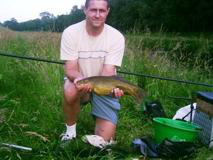

In [11]:
img = PIL.Image.open(img_fn)
img

In [12]:
import numpy
imga = numpy.array(img)

In [14]:
imga.shape

(160, 213, 3)

In [15]:
imga[:10,:10,0]

array([[244, 244, 244, 245, ..., 246, 246, 247, 247],
       [244, 244, 244, 245, ..., 246, 246, 247, 247],
       [244, 244, 244, 245, ..., 246, 246, 247, 247],
       [246, 246, 246, 247, ..., 248, 248, 248, 248],
       ...,
       [246, 246, 246, 247, ..., 248, 248, 247, 247],
       [247, 247, 247, 248, ..., 249, 249, 248, 248],
       [247, 247, 247, 247, ..., 247, 247, 248, 248],
       [247, 247, 247, 247, ..., 247, 247, 248, 248]], dtype=uint8)

In [16]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [17]:
' '.join(image_extensions)

'.ppm .xbm .jpe .svg .gif .xwd .xpm .pgm .pbm .ras .tiff .ico .ief .rgb .png .pnm .jpeg .bmp .jpg .tif'

In [18]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [20]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [21]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/anton/.fastai/data/imagenette2-160/n01440764_5642.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/n01440764_9091.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/n01440764_7462.JPEG')]

In [22]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [23]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n01440764/n01440764_5642.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n01440764/n01440764_9091.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/val/n01440764/n01440764_7462.JPEG')]

In [24]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_78.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_31075.JPEG'),
 PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_4683.JPEG')]

In [25]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [26]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

77.3 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling
What we need to do:

- Get files
- Split validation set
- random%, folder name, csv, ...
- Label:
- folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the ListContainer class from notebook 06 to store our objects in an ItemList. The get method will need to be subclassed to explain how to access an element (open an image for instance), then the private _get method can allow us to apply any additional transform to it.

new will be used in conjunction with __getitem__ (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [27]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, ImageList returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the ItemList and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an _order attribute (default 0) that is used to sort the transforms.

In [28]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [29]:
il = ImageList.from_files(path, tfms=make_rgb)

In [30]:
il

ImageList (13394 items)
[PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_78.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_31075.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_4683.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_11699.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_17387.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_38929.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_28515.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/ILSVRC2012_val_00009559.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_12378.JPEG'),...]
Path: /home/anton/.fastai/data/imagenette2-160

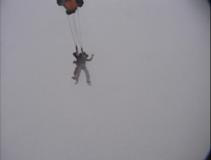

In [31]:
img = il[0]; img

In [32]:
il[:1]

[<PIL.Image.Image image mode=RGB size=211x160 at 0x7F95E85C0C18>]

### Split validation set

In [34]:
fn = il.items[0]; fn

PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_78.JPEG')

In [35]:
fn.parent.parent.name

'train'

In [36]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [37]:
splitter = partial(grandparent_splitter, valid_name='val')

In [38]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 38.6 ms


In [39]:
len(train),len(valid)

(9469, 3925)

In [40]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [41]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_78.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_31075.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_4683.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_11699.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_17387.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_38929.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_28515.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/ILSVRC2012_val_00009559.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_24216.JPEG'), PosixPath('/home/anton/.fastai/data/imagenette2-160/train/n03888257/n03888257_12378.JPEG'),...]
Path: /home/anton/.fastai/data/

### Labeling

Labeling has to be done after splitting, because it uses training set information to apply to the validation set, using a Processor.

A Processor is a transformation that is applied to all the inputs once at initialization, with some state computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be processing texts to tokenize, then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the Processor and applied on the validation set.

In our case, we want to convert label strings to numbers in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this vocab.

In [42]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

First, let's define the processor. We also define a ProcessedItemList with an obj method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding obj will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [43]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply fn.parent.name. We label the training set first with a newly created CategoryProcessor so that it computes its inner vocab on that set. Then we label the validation set using the same processor, which means it uses the same vocab. The end result is another SplitData object

In [44]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [45]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [46]:
assert ll.train.proc_y is ll.valid.proc_y

In [47]:
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...]
Path: /home/anton/.fastai/data/imagenette2-160

In [48]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03888257', ['n03888257', 'n03888257'])

### Transform to tensor

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

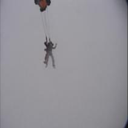

In [49]:
ll.train[0][0].resize((128,128))

In [52]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=211x160 at 0x7F95E84929E8>, 0)

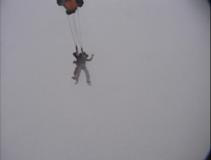

In [53]:
ll.train[0][0]

The first transform resizes to a given size, then we convert the image to a by tensor before converting it to float and dividing by 255. We will investigate data augmentation transforms at length in notebook 10.

In [54]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [55]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [56]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [57]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

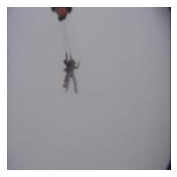

In [58]:
show_image(x)

### Modeling
#### DataBunch

In [59]:
bs=64

In [60]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [61]:
x,y = next(iter(train_dl))

In [62]:
x.shape

torch.Size([64, 3, 128, 128])

'n01440764'

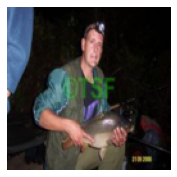

In [63]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [64]:
y

tensor([3, 4, 5, 4, 9, 8, 3, 6, 1, 5, 8, 4, 2, 7, 8, 1, 4, 3, 7, 6, 1, 3, 1, 4,
        1, 8, 7, 3, 5, 2, 5, 6, 9, 5, 2, 3, 8, 2, 2, 8, 4, 8, 5, 3, 6, 4, 9, 3,
        7, 1, 2, 4, 8, 7, 2, 5, 9, 8, 7, 8, 9, 2, 2, 3])

In [66]:
len(y)

64

We change a little bit our DataBunch to add a few attributes: c_in (for channel in) and c_out (for channel out) instead of just c. This will help when we need to build our model.

In [67]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [68]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [69]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

#### Model

In [70]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

In [71]:
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda()
m,s

(tensor([0.4295, 0.4162, 0.3725], device='cuda:0'),
 tensor([0.2608, 0.2574, 0.2764], device='cuda:0'))

In [72]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [73]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [74]:
nfs = [64,64,128,256]

We build our model using Bag of Tricks for Image Classification with Convolutional Neural Networks, in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

In [75]:
#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [76]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [77]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [81]:
%time run.fit(5, learn)

train: [1.8127054401203928, tensor(0.3676, device='cuda:0')]
valid: [3.176342555732484, tensor(0.2772, device='cuda:0')]
train: [1.4199014547470694, tensor(0.5233, device='cuda:0')]
valid: [1.4828297919984077, tensor(0.5343, device='cuda:0')]
train: [1.0684784931420952, tensor(0.6459, device='cuda:0')]
valid: [1.250010325437898, tensor(0.5990, device='cuda:0')]
train: [0.7005886086340954, tensor(0.7790, device='cuda:0')]
valid: [1.139809788017516, tensor(0.6431, device='cuda:0')]
train: [0.39183059420048316, tensor(0.8939, device='cuda:0')]
valid: [1.14628806727707, tensor(0.6418, device='cuda:0')]
CPU times: user 15.2 s, sys: 5.52 s, total: 20.8 s
Wall time: 1min 41s


In [83]:
%time run.fit(10, learn)

train: [0.32904749523939963, tensor(0.9103, device='cuda:0')]
valid: [1.3806914311305734, tensor(0.5954, device='cuda:0')]
train: [0.4443137124267346, tensor(0.8552, device='cuda:0')]
valid: [1.70872847830414, tensor(0.5552, device='cuda:0')]
train: [0.6179007649963038, tensor(0.7912, device='cuda:0')]
valid: [1.7459294138136943, tensor(0.5338, device='cuda:0')]
train: [0.37357738904583376, tensor(0.8791, device='cuda:0')]
valid: [1.5698722382563695, tensor(0.6046, device='cuda:0')]
train: [0.16480925730508766, tensor(0.9490, device='cuda:0')]
valid: [1.511902741839172, tensor(0.6252, device='cuda:0')]
train: [0.04437630359594466, tensor(0.9928, device='cuda:0')]
valid: [1.4982742834394904, tensor(0.6380, device='cuda:0')]
train: [0.01572012692321655, tensor(0.9986, device='cuda:0')]
valid: [1.4810334146098727, tensor(0.6397, device='cuda:0')]
train: [0.009089653715310321, tensor(0.9996, device='cuda:0')]
valid: [1.5085082852308918, tensor(0.6392, device='cuda:0')]
train: [0.0072481093

In [84]:
%%bash
python3 "../src/notebook2script.py" 07_data_block.ipynb

Converted 07_data_block.ipynb to ../src/nb_07.py
